#Mount your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install pytorch

In [ ]:
!pip install -q torch torchvision
!pip install -q cityscapesscripts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.6/473.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.5 MB/s eta 0:00:00


#Define ICNET model

##Implement Max Attention Supression and Random Attention Dropout to increase robustness

## Model architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes=[1, 2, 3, 6]):
        super(PyramidPooling, self).__init__()
        self.pools = nn.ModuleList([
            nn.AdaptiveAvgPool2d(output_size=size) for size in pool_sizes
        ])
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, in_channels // len(pool_sizes), kernel_size=1, bias=False) for _ in pool_sizes
        ])
        out_channels = in_channels + (in_channels // len(pool_sizes)) * len(pool_sizes)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        size = x.shape[2:]
        out = [x]
        for pool, conv in zip(self.pools, self.convs):
            pooled = pool(x)
            conv_out = conv(pooled)
            out.append(F.interpolate(conv_out, size=size, mode='bilinear', align_corners=True))
        out = torch.cat(out, dim=1)
        return self.relu(self.bn(out))


class CascadeFeatureFusion(nn.Module):
    """CFF Unit"""
    def __init__(self, low_channels, high_channels, out_channels, n_classes):
        super(CascadeFeatureFusion, self).__init__()
        self.conv_low = nn.Sequential(
            nn.Conv2d(low_channels, out_channels, kernel_size=3, padding=2, dilation=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.conv_high = nn.Sequential(
            nn.Conv2d(high_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.conv_low_cls = nn.Conv2d(out_channels, n_classes, kernel_size=1, bias=False)

    def forward(self, x_low, x_high):
        x_low = F.interpolate(x_low, size=x_high.shape[2:], mode='bilinear', align_corners=True)
        x_low = self.conv_low(x_low)
        x_high = self.conv_high(x_high)
        x = F.relu(x_low + x_high, inplace=True)
        x_low_cls = self.conv_low_cls(x_low)
        return x, x_low_cls


class SemanticSegmentationModel(nn.Module):
    def __init__(self, n_classes=8):
        super(SemanticSegmentationModel, self).__init__()
        resnet = resnet50(weights='IMAGENET1K_V1')
        self.initial_layers = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool
        )
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.pyramid_pooling = PyramidPooling(2048)

        self.cff_24 = CascadeFeatureFusion(low_channels=4096, high_channels=1024, out_channels=512, n_classes=n_classes)
        self.cff_12 = CascadeFeatureFusion(low_channels=512, high_channels=512, out_channels=128, n_classes=n_classes)

        self.classifier = nn.Conv2d(128, n_classes, kernel_size=1)

    def forward(self, x):
        x = self.initial_layers(x)
        c1 = self.layer1(x)
        c2 = self.layer2(c1)
        c3 = self.layer3(c2)
        c4 = self.layer4(c3)

        # Pass through PyramidPooling
        c4 = self.pyramid_pooling(c4)

        # Feature fusion
        c3_c4, aux_c3_c4 = self.cff_24(c4, c3)  # c3: 1024 channels, c4: 4096 channels
        c1_c2_c3, aux_c1_c2 = self.cff_12(c3_c4, c2)  # c3_c4: 512 channels, c2: 512 channels

        out = self.classifier(c1_c2_c3)

        # Upsample to match original input size
        out = F.interpolate(out, size=(128, 256), mode='bilinear', align_corners=False)
        aux_c3_c4 = F.interpolate(aux_c3_c4, size=(128, 256), mode='bilinear', align_corners=False)
        aux_c1_c2 = F.interpolate(aux_c1_c2, size=(128, 256), mode='bilinear', align_corners=False)
        return out, aux_c3_c4, aux_c1_c2


#Fetch data and transform

In [ ]:
from glob import glob
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import os

class CityscapesCustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, dataset_type="clean", transform=None):
        """
        Custom Cityscapes Dataset.
        - root_dir: Root directory of the dataset containing images and labels.
        - dataset_type: Either "clean" or "adversarial".
        - transform: Transformations to apply to images (labels remain untransformed).
        """
        self.root_dir = root_dir
        self.transform = transform

        # Define subdirectories for images and labels
        if dataset_type == "clean":
            self.image_dir = os.path.join(root_dir, "Clean Images")
        elif dataset_type == "adversarial":
            self.image_dir = os.path.join(root_dir, "Adverserial Images")
        else:
            raise ValueError(f"Unknown dataset_type: {dataset_type}. Use 'clean' or 'adversarial'.")

        self.label_dir = os.path.join(root_dir, "Labels")  # Labels are shared

        # Get list of all images and corresponding labels
        self.image_paths = sorted(os.listdir(self.image_dir))
        self.label_paths = sorted(os.listdir(self.label_dir))

        # Ensure correspondence between images and labels
        assert len(self.image_paths) == len(self.label_paths), "Mismatch between images and labels"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image and label
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        label_path = os.path.join(self.label_dir, self.label_paths[idx])

        # Load image and label
        image = Image.open(image_path).convert("RGB")  # Load as RGB
        label = Image.open(label_path)  # Labels are grayscale

        # Apply transformation to the image only
        if self.transform:
            image = self.transform(image)

        # Convert label to a tensor without transformation
        label = torch.tensor(np.array(label), dtype=torch.long)

        return image, label


#Make some transformations to the images and load them to a dataloader for training

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
import random
from torch.utils.data import ConcatDataset, random_split

# Define transformations
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Root directory containing the dataset folders
root_dir = '/content/drive/MyDrive/Cityscapes'

clean_dataset = CityscapesCustomDataset(root_dir=root_dir, dataset_type="clean", transform=image_transform)
#adv_dataset = CityscapesCustomDataset(root_dir=root_dir, dataset_type="adversarial", transform=image_transform)

# Combine datasets
combined_dataset = clean_dataset
#combined_dataset = ConcatDataset([clean_dataset, adv_dataset])

# Split into training and validation sets
train_size = int(0.75 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)

#Define progress bar

In [ ]:
!pip install tqdm

#Define function to calculate the MIoU

In [ ]:
import torch
import numpy as np

def calculate_iou(pred, target, num_classes):
    """
    Calculate IoU for each class over a batch.
    Args:
        pred: Predicted tensor of shape (batch_size, height, width)
        target: Ground truth tensor of shape (batch_size, height, width)
        num_classes: Total number of classes.
    Returns:
        miou: Mean IoU over all classes.
    """
    ious = []

    # Flatten predictions and targets across the batch
    pred = pred.view(-1)  # Shape: (batch_size * height * width)
    target = target.view(-1)  # Shape: (batch_size * height * width)

    for cls in range(num_classes):
        # True Positive (intersection)
        intersection = ((pred == cls) & (target == cls)).sum().item()
        # Union
        union = ((pred == cls) | (target == cls)).sum().item()

        if union == 0:
            ious.append(float('nan'))  # Ignore classes not present in the batch
        else:
            ious.append(intersection / union)

    # Calculate mean IoU, ignoring NaN values
    miou = np.nanmean(ious)
    return miou

#Define a train and validate function for the model to learn form the images in the dataloader

In [ ]:
def train(model, dataloader, criterion, optimizer, device, num_classes=8):
    model.train()
    total_loss = 0.0

    with tqdm(dataloader, desc="Training", leave=False) as pbar:
        for imgs, labels in pbar:
            # Move data to the device
            imgs, labels = imgs.to(device), labels.to(device, dtype=torch.long)

            # Mask out ignored regions (-1)
            valid_mask = labels >= 0  # Boolean mask for valid pixels
            labels = torch.where(valid_mask, labels, torch.zeros_like(labels))  # Replace -1 with 0 for loss computation

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(imgs)

            # Handle different output formats (e.g., tuple, dictionary, tensor)
            if isinstance(outputs, dict) and "out" in outputs:
                outputs = outputs["out"]  # Extract primary output (e.g., from torchvision models)
            elif isinstance(outputs, tuple):
                outputs = outputs[0]  # Extract the first element if outputs is a tuple

            # Resize outputs to match labels
            if outputs.shape[-2:] != labels.shape[-2:]:
                outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=False)

            # Compute loss only on valid pixels
            loss = criterion(outputs, labels) * valid_mask.float()
            loss = loss.sum() / valid_mask.sum()  # Normalize by the number of valid pixels

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Track and log loss
            total_loss += loss.item()
            pbar.set_postfix({'Avg Loss': total_loss / (pbar.n + 1)})

    return total_loss / len(dataloader)


Create a validation function to validate the model on the validation set

In [ ]:
import torch.nn.functional as F
from tqdm import tqdm

def validate(model, dataloader, criterion, device, num_classes=8):
    model.eval()
    total_loss = 0.0
    total_miou = 0.0

    with torch.no_grad():
        with tqdm(dataloader, desc="Validating", leave=False) as pbar:
            for imgs, labels in pbar:
                # Move data to the device
                imgs, labels = imgs.to(device), labels.to(device, dtype=torch.long)

                # Forward pass
                outputs = model(imgs)

                # Handle different output formats (e.g., tuple, dictionary, tensor)
                if isinstance(outputs, dict) and "out" in outputs:
                    outputs = outputs["out"]  # Extract primary output (e.g., from torchvision models)
                elif isinstance(outputs, tuple):
                    outputs = outputs[0]  # Extract the first element if outputs is a tuple

                # Resize outputs to match labels
                if outputs.shape[-2:] != labels.shape[-2:]:
                    outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=False)

                # Compute loss
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                # Calculate mIoU
                preds = torch.argmax(outputs, dim=1)  # Convert logits to class indices
                miou = calculate_iou(preds, labels, num_classes)
                total_miou += miou

                # Log metrics
                pbar.set_postfix({'Avg Loss': total_loss / (pbar.n + 1), 'Avg mIoU': total_miou / (pbar.n + 1)})

    avg_loss = total_loss / len(dataloader)
    avg_miou = total_miou / len(dataloader)
    return avg_loss, avg_miou


#Implement Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, save_path='best_model.pth'):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            delta (float): Minimum change to qualify as an improvement.
            save_path (str): Path to save the best model.
        """
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_score = None
        self.epochs_without_improvement = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        # If it's the first epoch, save the initial model
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        # Check if the current validation loss is better than the best score recorded
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.epochs_without_improvement = 0
            self.save_checkpoint(model)
        else:
            self.epochs_without_improvement += 1
            if self.epochs_without_improvement >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        """Save the model when validation loss decreases."""
        torch.save(model.state_dict(), self.save_path)
        print(f"Model improved")


#Train model and use loss,MIoU and validation loss to make improvements on overfitting or underfitting

In [ ]:
import torch
import random
import numpy as np
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SemanticSegmentationModel().to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
miou_scores = []

# Initialize early stopping
early_stopping = EarlyStopping(patience=15, delta=0.001, save_path='best_model.pth')

num_epochs = 50
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train the model for one epoch
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validate the model
    val_loss, val_miou = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    miou_scores.append(val_miou)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mIoU: {val_miou:.4f}")

    # Check early stopping condition
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

# Save final metrics for analysis
final_metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "miou_scores": miou_scores
}
torch.save(final_metrics, 'training_metrics.pth')

print("Training complete.")


Epoch 1/50


Train Loss: 0.4804 | Val Loss: 0.5017 | mIoU: 0.5365
Model improved
Epoch 2/50


Train Loss: 0.4056 | Val Loss: 0.4051 | mIoU: 0.5955
Model improved
Epoch 3/50


Train Loss: 0.3795 | Val Loss: 0.4568 | mIoU: 0.5799
Epoch 4/50


Train Loss: 0.3599 | Val Loss: 0.3887 | mIoU: 0.6126
Model improved
Epoch 5/50


Train Loss: 0.3438 | Val Loss: 0.3850 | mIoU: 0.6244
Model improved
Epoch 6/50


Train Loss: 0.3324 | Val Loss: 0.4069 | mIoU: 0.6069
Epoch 7/50


Train Loss: 0.3250 | Val Loss: 0.3754 | mIoU: 0.6225
Model improved
Epoch 8/50


Train Loss: 0.3331 | Val Loss: 0.4601 | mIoU: 0.5709
Epoch 9/50


Train Loss: 0.3107 | Val Loss: 0.4013 | mIoU: 0.6102
Epoch 10/50


Train Loss: 0.2863 | Val Loss: 0.3749 | mIoU: 0.6327
Epoch 11/50


Train Loss: 0.2764 | Val Loss: 0.4030 | mIoU: 0.6098
Epoch 12/50


Train Loss: 0.2814 | Val Loss: 0.4722 | mIoU: 0.6017
Epoch 13/50


Train Loss: 0.2746 | Val Loss: 0.4283 | mIoU: 0.6111
Epoch 14/50


Train Loss: 0.2641 | Val Loss: 0.3624 | mIoU: 0.6386
Model improved
Epoch 15/50


Train Loss: 0.2440 | Val Loss: 0.3687 | mIoU: 0.6468
Epoch 16/50


Train Loss: 0.2485 | Val Loss: 0.3885 | mIoU: 0.6368
Epoch 17/50


Train Loss: 0.2418 | Val Loss: 0.3961 | mIoU: 0.6397
Epoch 18/50


Train Loss: 0.2354 | Val Loss: 0.4001 | mIoU: 0.6313
Epoch 19/50


Train Loss: 0.2221 | Val Loss: 0.3965 | mIoU: 0.6530
Epoch 20/50


Train Loss: 0.2144 | Val Loss: 0.3934 | mIoU: 0.6475
Epoch 21/50


Train Loss: 0.2125 | Val Loss: 0.4456 | mIoU: 0.6138
Epoch 22/50


Train Loss: 0.2352 | Val Loss: 0.3911 | mIoU: 0.6518
Epoch 23/50


Train Loss: 0.2087 | Val Loss: 0.4174 | mIoU: 0.6421
Epoch 24/50


Train Loss: 0.2009 | Val Loss: 0.4076 | mIoU: 0.6530
Epoch 25/50


Train Loss: 0.2923 | Val Loss: 0.3983 | mIoU: 0.6180
Epoch 26/50


Train Loss: 0.2421 | Val Loss: 0.3979 | mIoU: 0.6450
Epoch 27/50


Train Loss: 0.2103 | Val Loss: 0.4001 | mIoU: 0.6504
Epoch 28/50


Train Loss: 0.2189 | Val Loss: 0.3956 | mIoU: 0.6554
Epoch 29/50


Train Loss: 0.1974 | Val Loss: 0.4008 | mIoU: 0.6539
Early stopping triggered. Stopping training.
Training complete.


#Vizualize the model's predictions

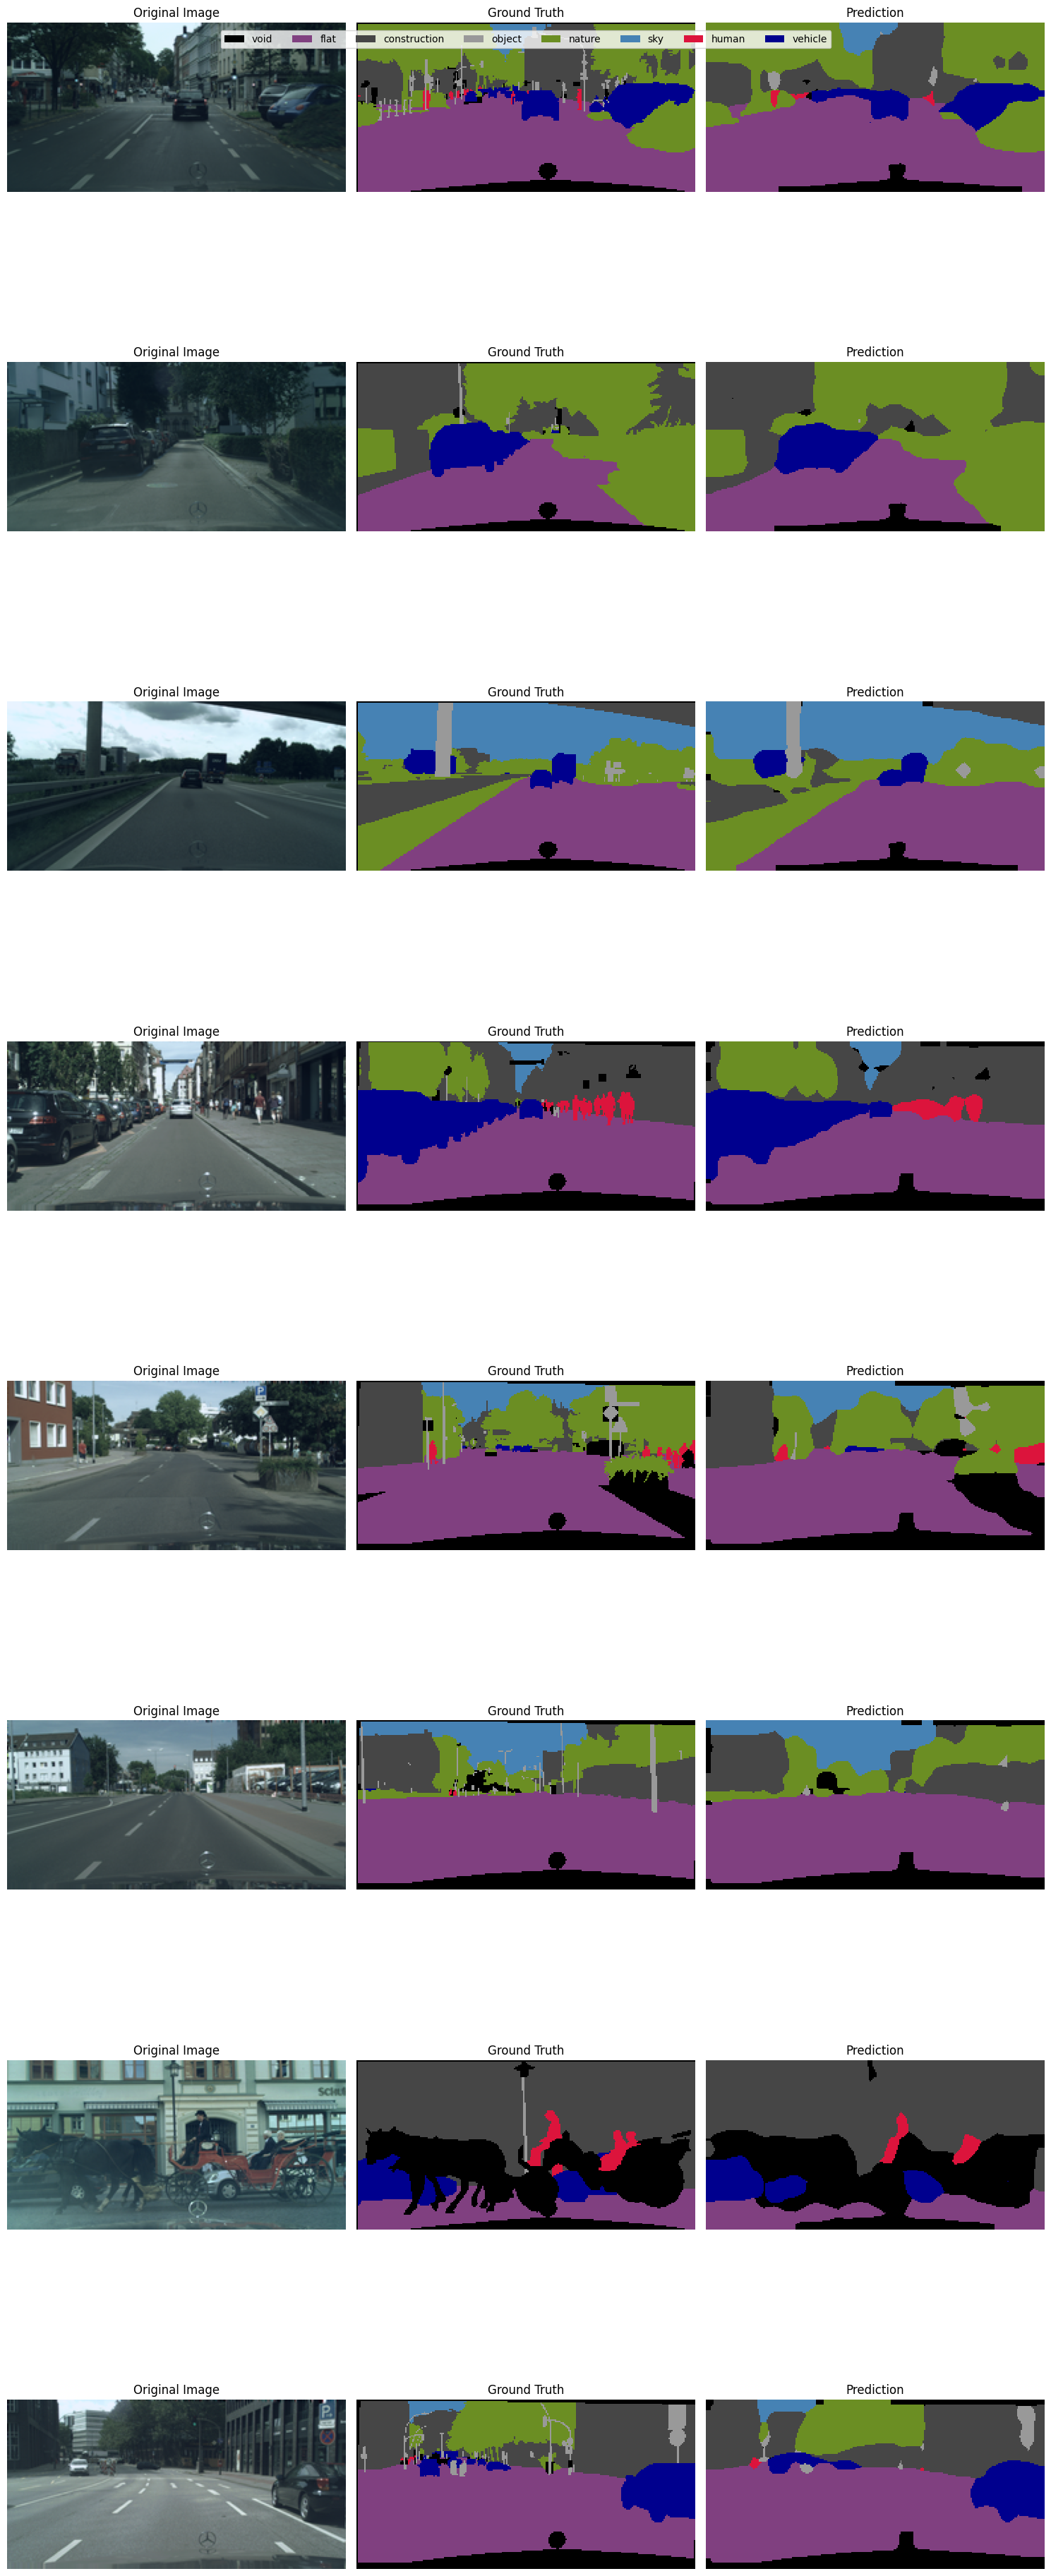

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import torch


def visualize_batch(images, labels, preds, class_colors, class_names=None):
    """
    Visualizes a batch of original images, target masks, and predicted masks.

    Args:
        images: Tensor of shape (batch_size, channels, height, width)
        labels: Tensor of shape (batch_size, height, width)
        preds: Tensor of shape (batch_size, height, width)
        class_colors: List of RGB tuples for each class.
        class_names: Optional list of class names for a legend.
    """
    batch_size = images.shape[0]

    # Create a color map for segmentation masks
    cmap = ListedColormap(np.array(class_colors) / 255.0)  # Normalize colors to [0, 1]

    # Create a grid of subplots: each row for one sample (original, ground truth, prediction)
    fig, axes = plt.subplots(batch_size, 3, figsize=(15, 5 * batch_size))

    # If batch size is 1, adjust axes to avoid indexing issues
    if batch_size == 1:
        axes = axes[np.newaxis, :]

    for i in range(batch_size):
        # Convert image to numpy and normalize to [0, 1]
        img = images[i].permute(1, 2, 0).cpu().numpy()  # (height, width, channels)
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization

        # Convert labels and predictions to numpy arrays
        label = labels[i].cpu().numpy()
        pred = preds[i].cpu().numpy()

        # Plot the original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Plot the ground truth with the colormap
        axes[i, 1].imshow(label, cmap=cmap, interpolation="nearest")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        # Plot the predictions with the colormap
        axes[i, 2].imshow(pred, cmap=cmap, interpolation="nearest")
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")

    # Add a legend for class names if provided
    if class_names is not None:
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=np.array(color) / 255.0, label=name)
            for color, name in zip(class_colors, class_names)
        ]
        fig.legend(
            handles=legend_elements,
            loc="upper center",
            ncol=len(class_names),
            bbox_to_anchor=(0.5, 0.95),
        )

    plt.tight_layout()
    plt.show()


# Example Usage:
# Assuming you have a DataLoader (`val_loader`) and a trained model
for images, labels in val_loader:
    # Move images and labels to the device (e.g., GPU)
    images = images.to(device)  # Shape: (batch_size, channels, height, width)
    labels = labels.to(device)  # Shape: (batch_size, height, width)

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images)[0]  # Outputs shape: (batch_size, num_classes, height, width)
        preds = torch.argmax(outputs, dim=1)  # Convert logits to class indices

    # Define class colors (RGB tuples)
    class_colors = [
    (0, 0, 0),         # void: Black
    (128, 64, 128),    # flat (road, sidewalk): Purple
    (70, 70, 70),      # construction (building, wall): Dark gray
    (153, 153, 153),   # object (poles, signs): Light gray
    (107, 142, 35),    # nature (trees, vegetation): Green
    (70, 130, 180),    # sky: Light blue
    (220, 20, 60),     # human (pedestrians, cyclists): Red
    (0, 0, 142)        # vehicle: Dark blue
]

    # Define class names
    class_names = [
        "void",
        "flat",
        "construction",
        "object",
        "nature",
        "sky",
        "human",
        "vehicle",
    ]

    # Visualize the batch
    visualize_batch(images, labels, preds, class_colors, class_names)
    break  # Exit after visualizing the first batch


#Vizualize the convergance of the model

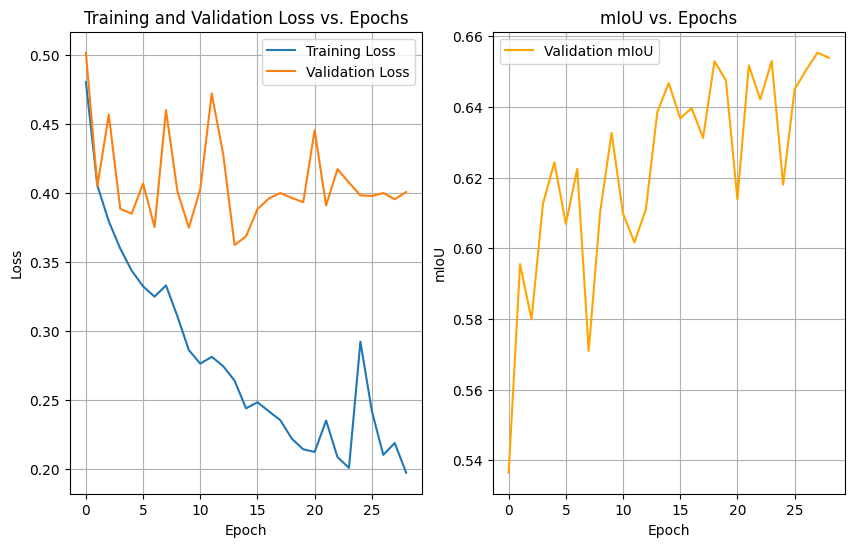

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot Training and Validation Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)

# Plot mIoU vs. Epochs
plt.subplot(1,2,2)
plt.plot(miou_scores, label='Validation mIoU', color='orange')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('mIoU vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()
